In [1]:
import random
import warnings

import jax.numpy as jnp
import pyenzyme as pe

import catalax as ctx
import catalax.mcmc as cmc

ctx.set_host_count(4)

warnings.filterwarnings("ignore")

# Working with inhomogeneous data

Sometimes datasets are not homogeneous—for example, when certain measurements contain more or fewer time points than others. In addition, some data may be missing because specific measurements were deemed invalid and removed.

For this case, catalax provides the means to work with nan-masked data. In this way. Measurements of different lengths can be padded with nan values to make them the same length.

In the following example, data from an EnzymeML Document conatining synthetic data of a Michaelis-Menten reaction with time dependent enzyme inactivation is used.

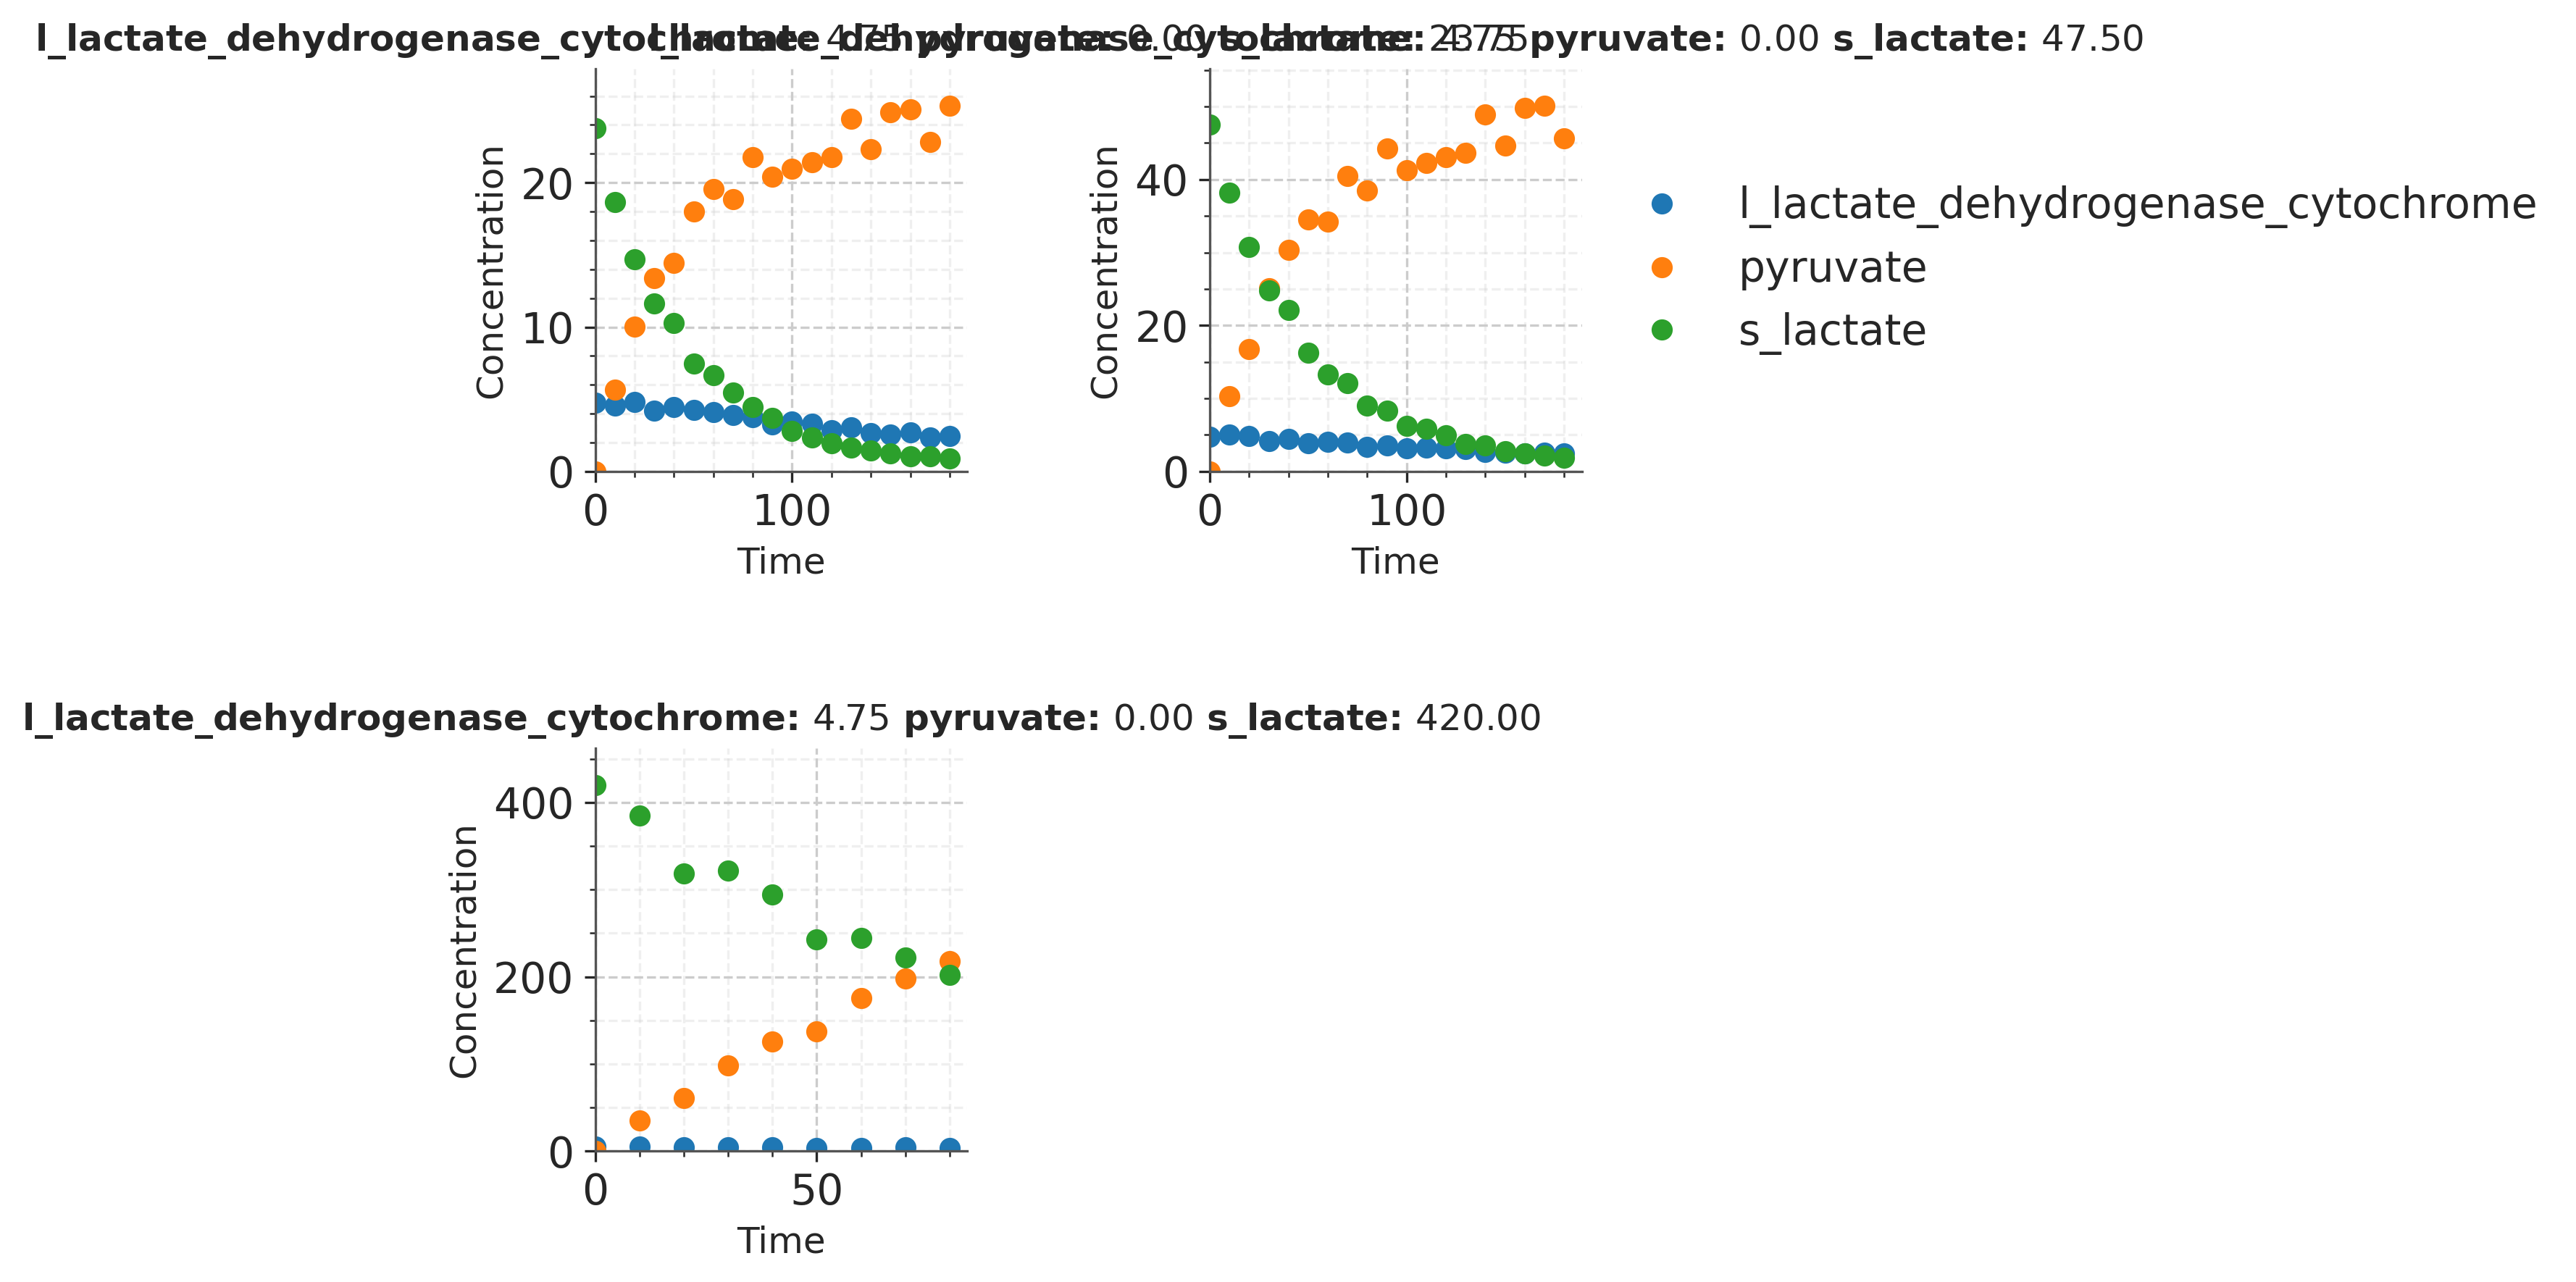

Length of time: 19, | Length of data: [19, 19, 19]
Length of time: 19, | Length of data: [19, 19, 19]
Length of time: 9, | Length of data: [9, 9, 9]


In [8]:
enzml = pe.read_enzymeml("datasets/enzymeml_inactivation.json")

# shorten last measurement to simulate shorter measurement
for idx, species in enumerate(enzml.measurements[-1].species_data):
    if species.data:
        enzml.measurements[-1].species_data[idx].data = species.data[:-10]
        enzml.measurements[-1].species_data[idx].time = species.time[:-10]

dataset, model = ctx.from_enzymeml(enzml)

# plot the dataset
dataset.plot(show=True)

# print array lengths before
for meas in dataset.measurements:
    lengths = []
    for v in meas.data.values():
        lengths.append(v.size)
    print(f"Length of time: {meas.time.size}, | Length of data: {lengths}")

### Pad and model dataset

In [9]:
# create padded dataset
padded_dataset = dataset.pad()

# plot array lengths before
for meas in padded_dataset.measurements:
    lengths = []
    for v in meas.data.values():
        lengths.append(v.size)
    print(f"Length of time: {meas.time.size}, | Length of data: {lengths}")


Length of time: 19, | Length of data: [19, 19, 19]
Length of time: 19, | Length of data: [19, 19, 19]
Length of time: 19, | Length of data: [19, 19, 19]


In [4]:
# define priors
model.parameters.k_cat.prior = cmc.priors.Uniform(low=0.1, high=2)
model.parameters.K_M.prior = cmc.priors.Uniform(low=100, high=500)
model.parameters.k_inact.prior = cmc.priors.Uniform(low=0.0001, high=0.01)


# run mcmc
hmc = cmc.HMC(
    num_warmup=1000,
    num_samples=1000,
    num_chains=4,
    chain_method="parallel",
)
results = hmc.run(model=model, dataset=padded_dataset, yerrs=2.0)

# Apply the median posterior to the model
fitted_model = results.get_fitted_model()

results.summary()


🚀 Running MCMC



  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
K_M,187.057,5.462,176.730,197.877,0.088,0.062,3879.0,2936.0,1.0
k_cat,1.098,0.013,1.070,1.122,0.000,0.000,4060.0,2646.0,1.0
k_inact,0.004,0.000,0.004,0.005,0.000,0.000,4168.0,2691.0,1.0
sigma,1.005,0.082,0.838,1.159,0.001,0.001,3732.0,2926.0,1.0


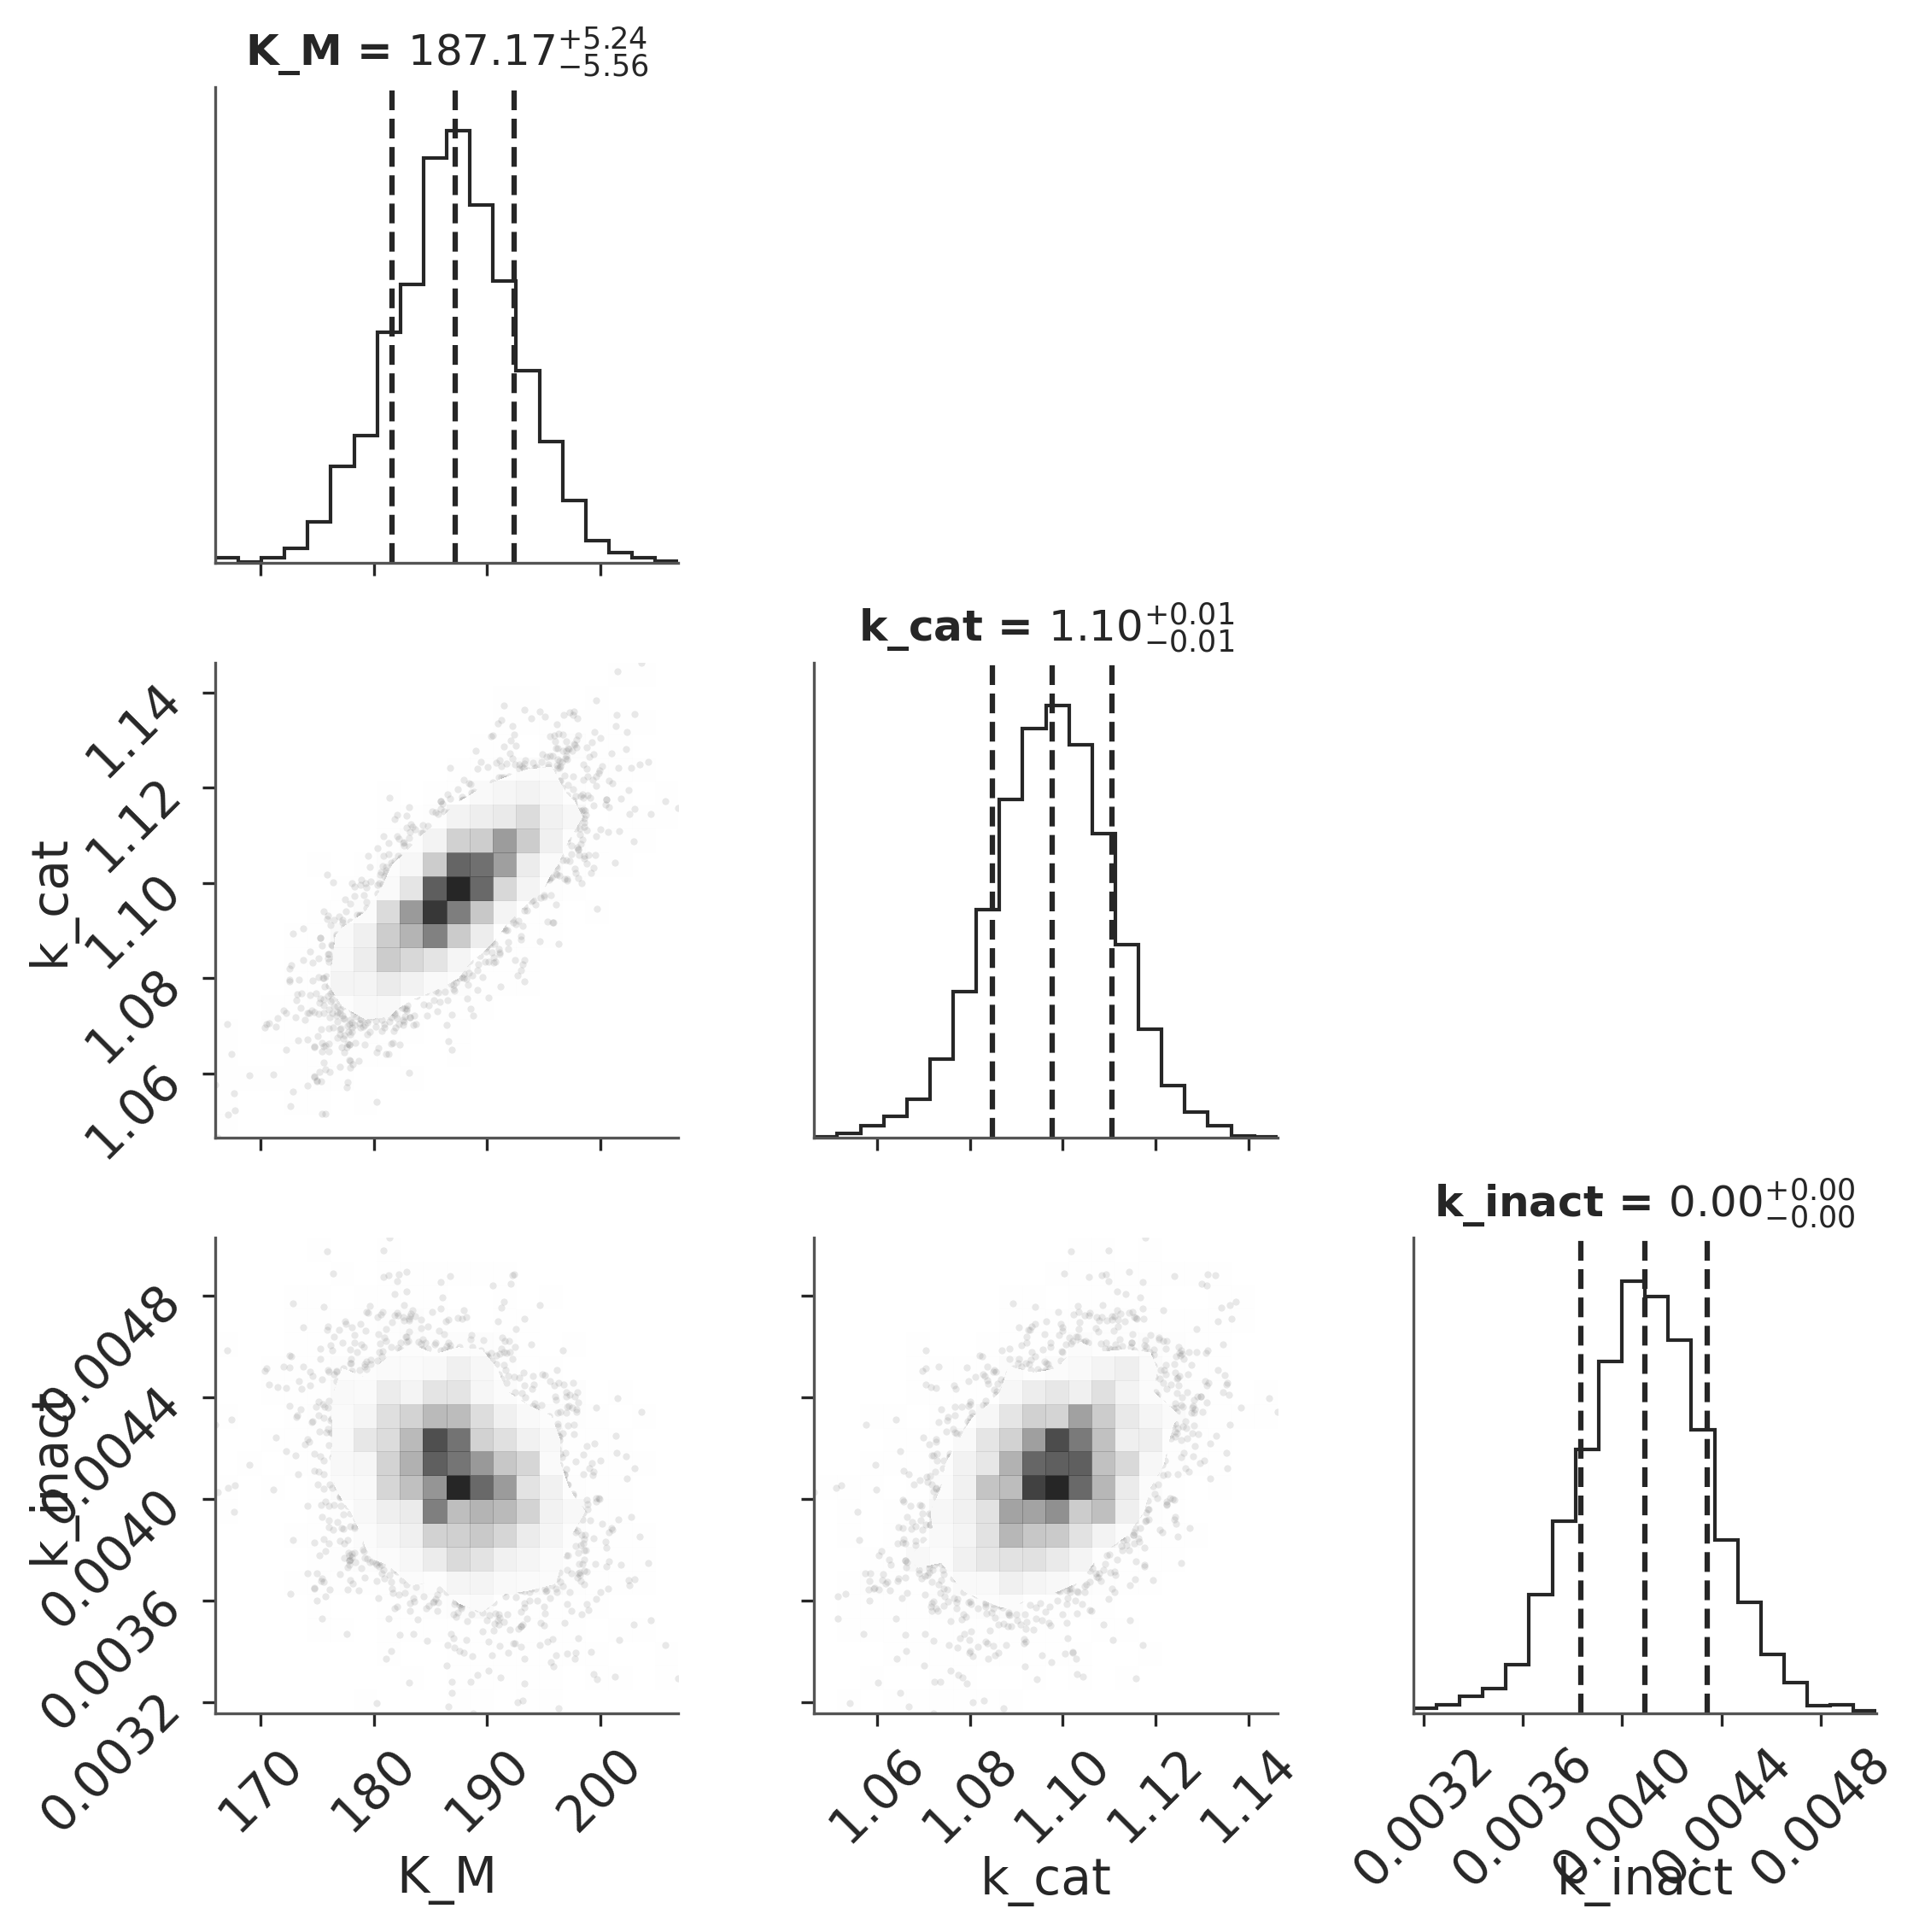

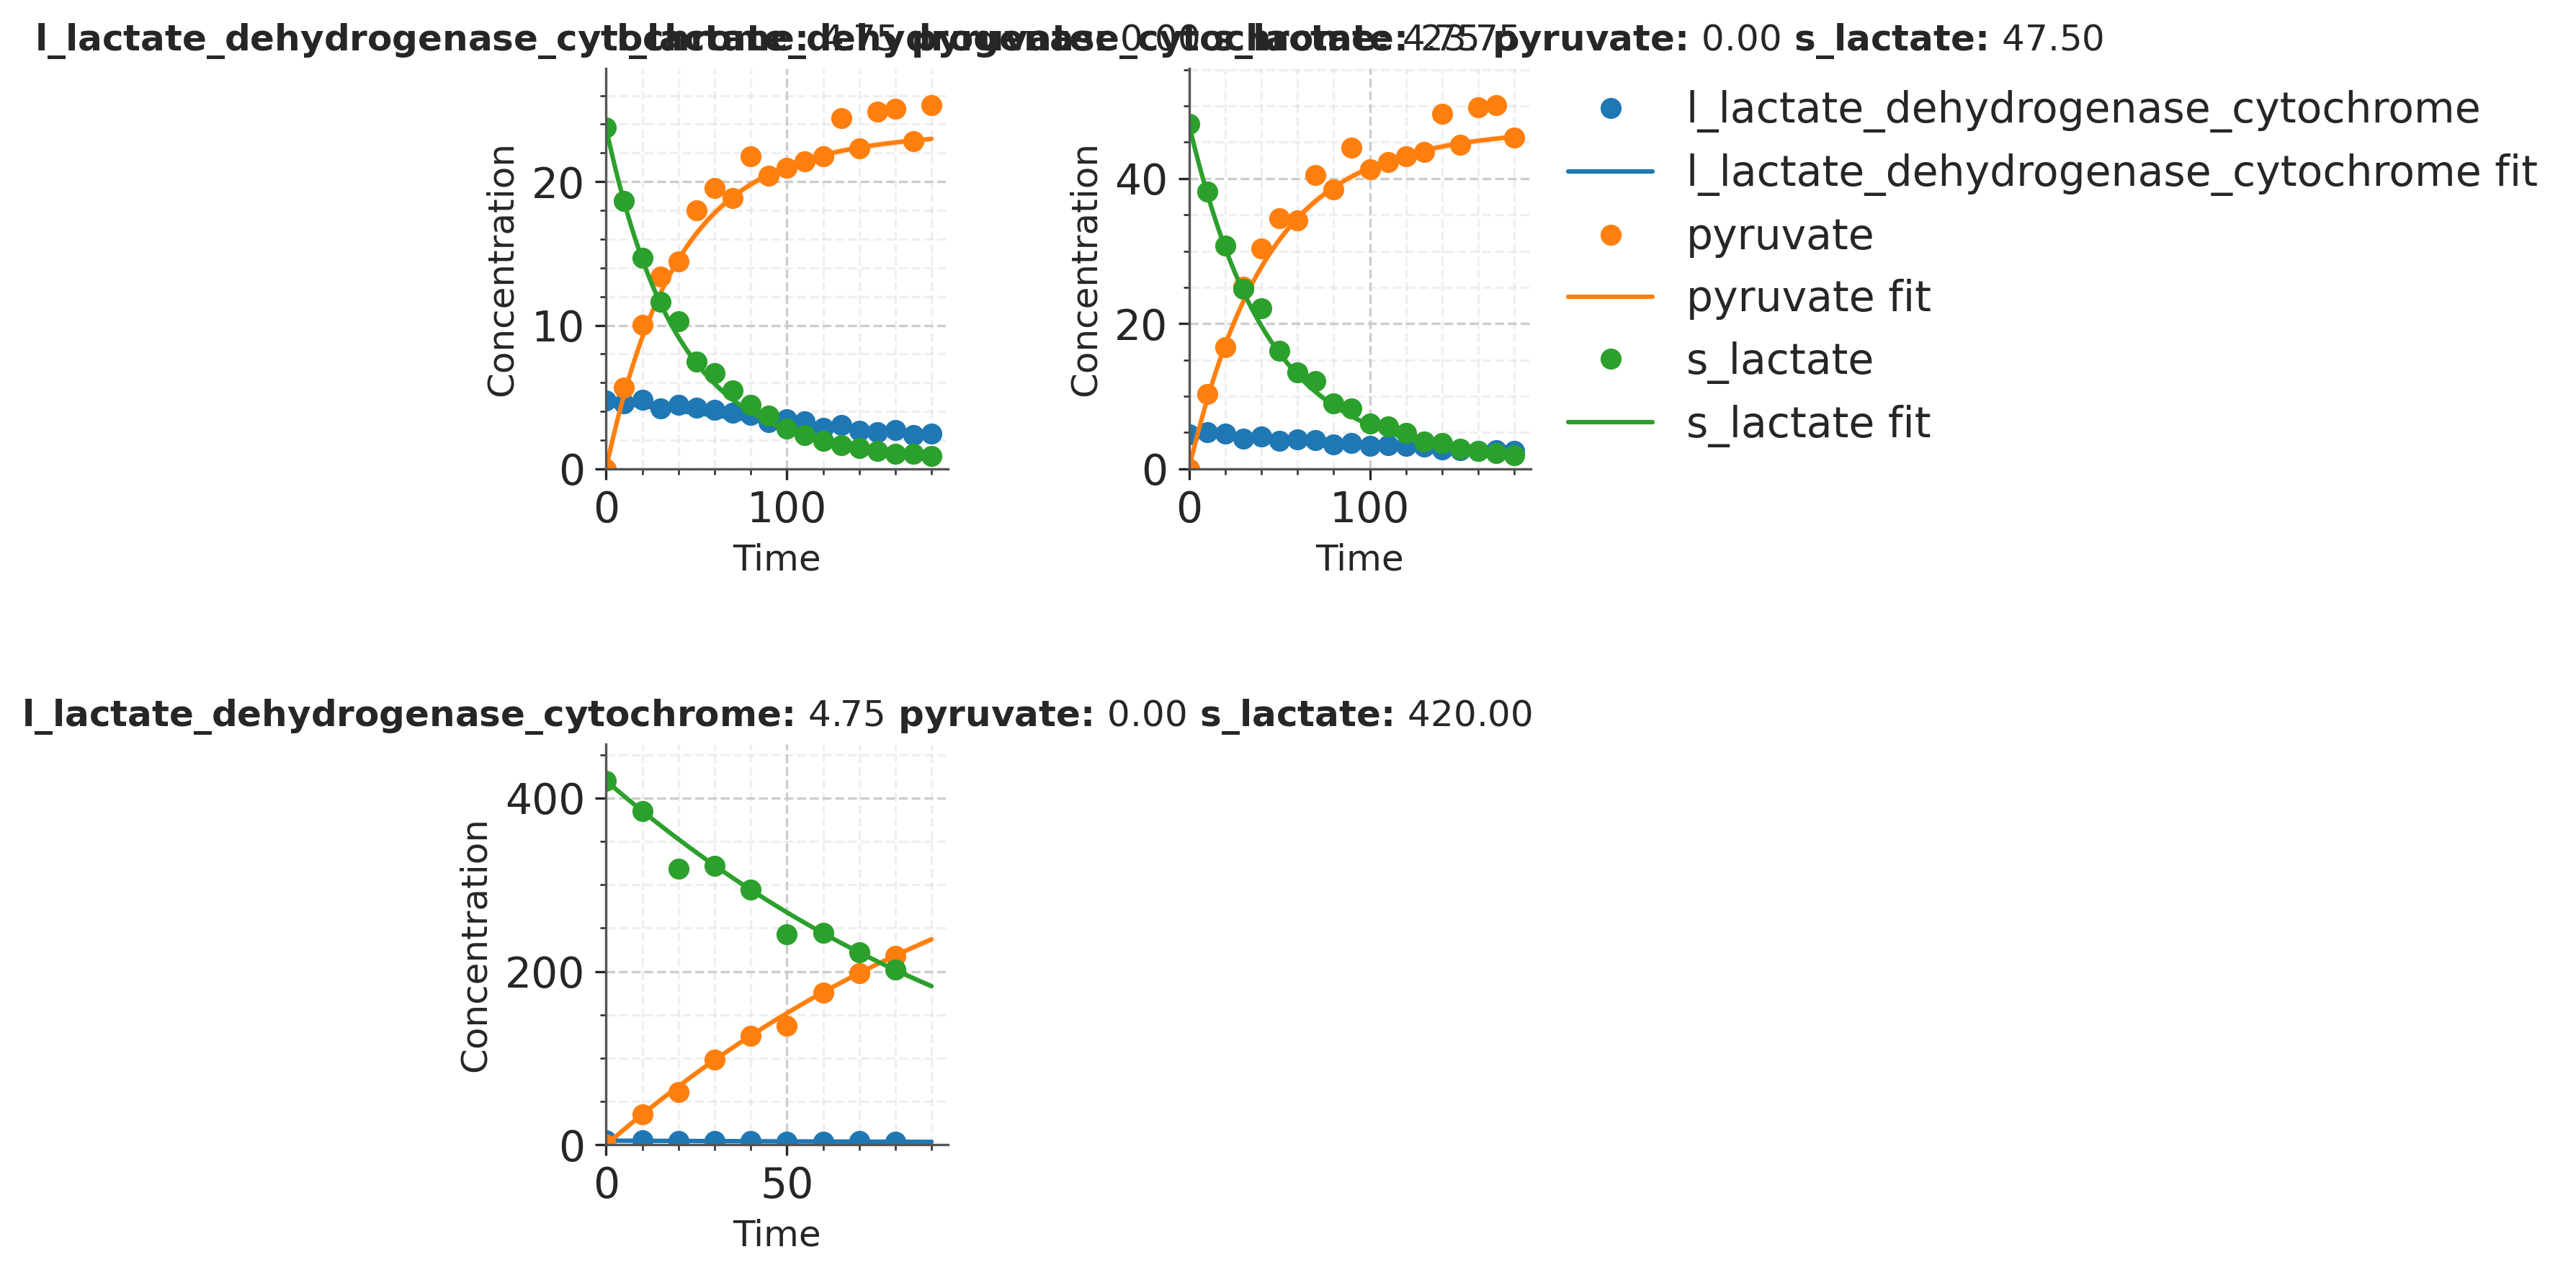

In [5]:
# plot results
results.plot_corner(show=True)

padded_dataset.plot(
    predictor=fitted_model,
    show=True,
)

### Heavily masked data



In [6]:
# mask 80% of the data with nan
for meas in padded_dataset.measurements:
    for k, v in meas.data.items():
        d = v.tolist()
        mask = random.sample(range(len(d)), int(0.8 * len(d)))
        for i in mask:
            d[i] = jnp.nan
        meas.data[k] = jnp.array(d)

hmc = cmc.HMC(
    num_warmup=1000,
    num_samples=1000,
    num_chains=4,
    chain_method="parallel",
)
masked_results = hmc.run(model=model, dataset=padded_dataset, yerrs=2.0)

# Apply the median posterior to the model
masked_fitted_model = masked_results.get_fitted_model()

masked_results.summary()



🚀 Running MCMC



  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
K_M,188.795,32.265,130.508,254.865,0.956,0.705,1332.0,1274.0,1.0
k_cat,1.145,0.080,1.000,1.310,0.002,0.002,1352.0,782.0,1.0
k_inact,0.005,0.002,0.002,0.008,0.000,0.000,2195.0,1308.0,1.0
sigma,2.466,0.431,1.641,3.282,0.010,0.007,2155.0,1949.0,1.0


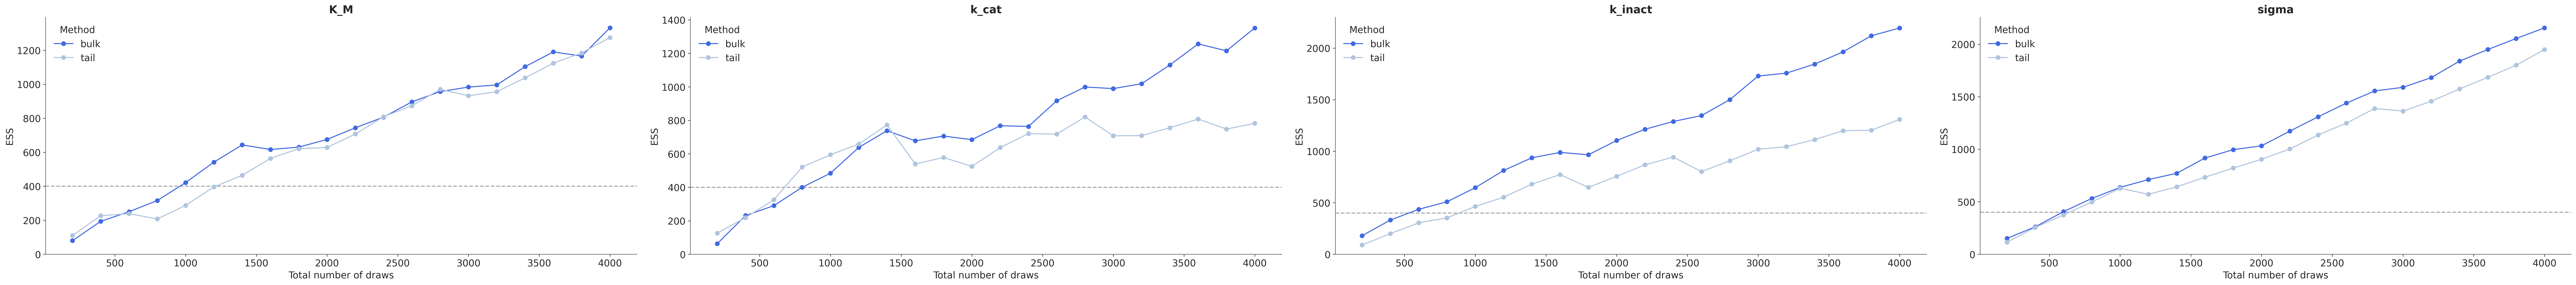

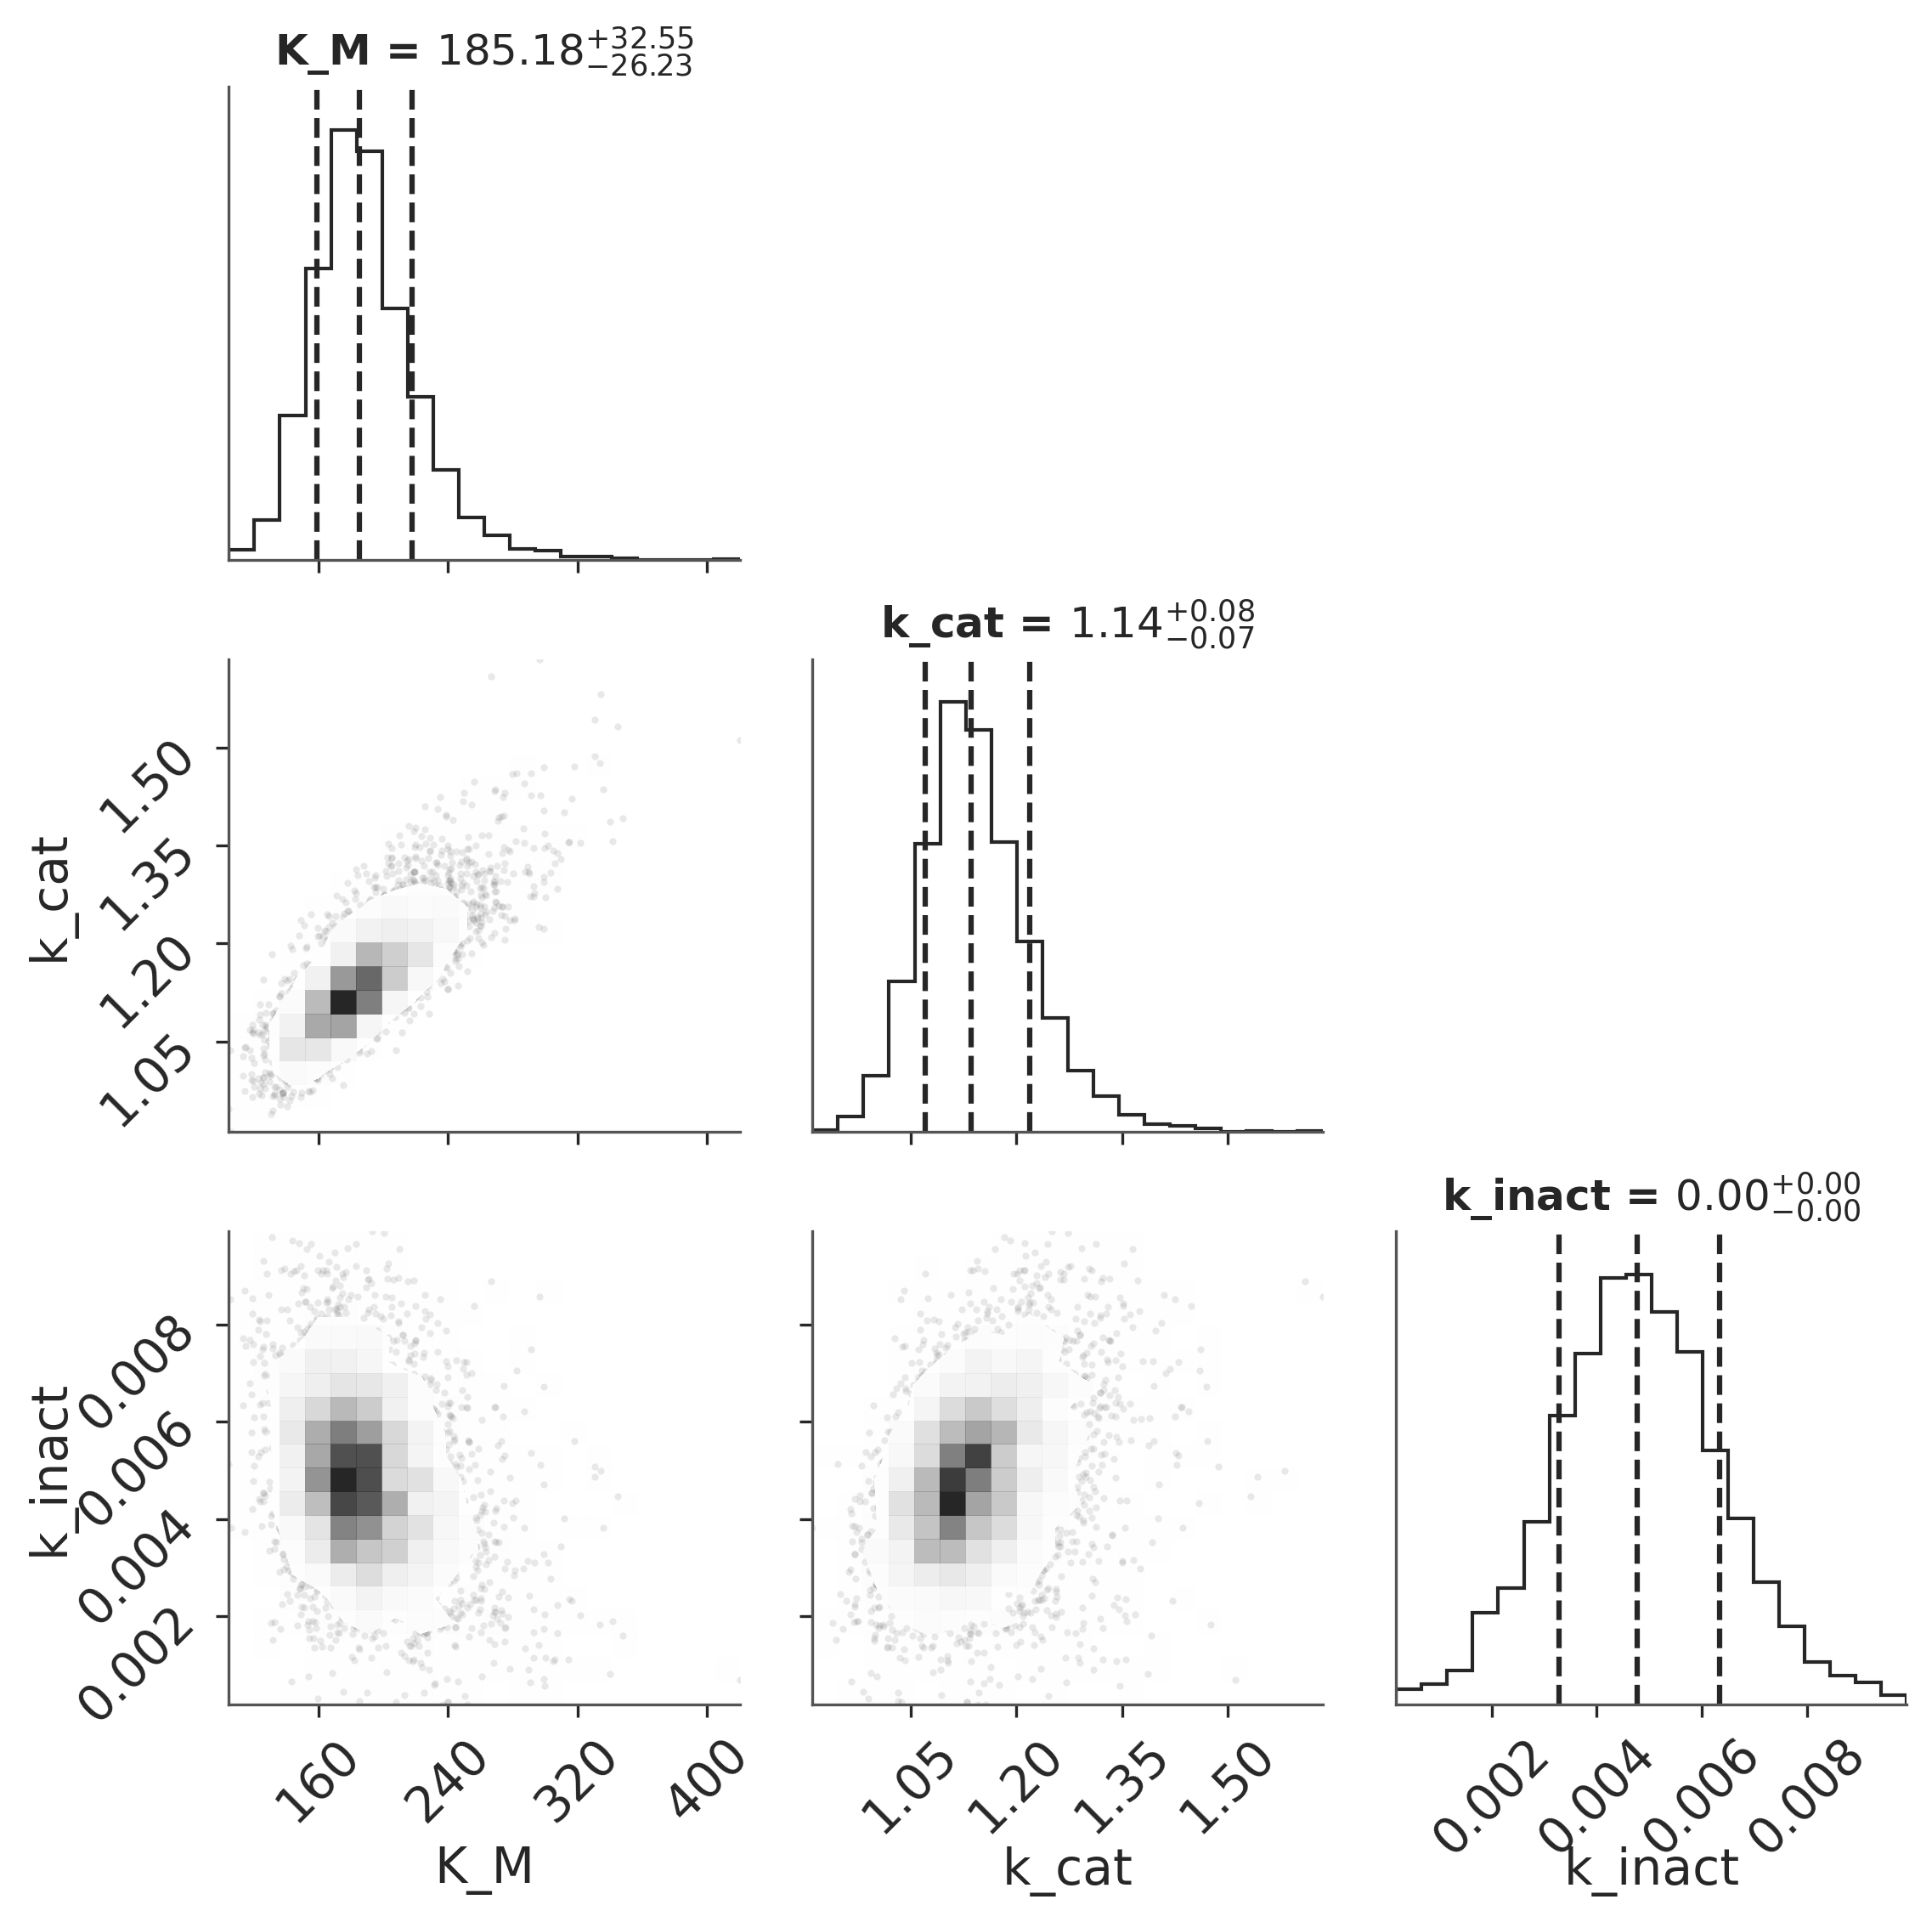

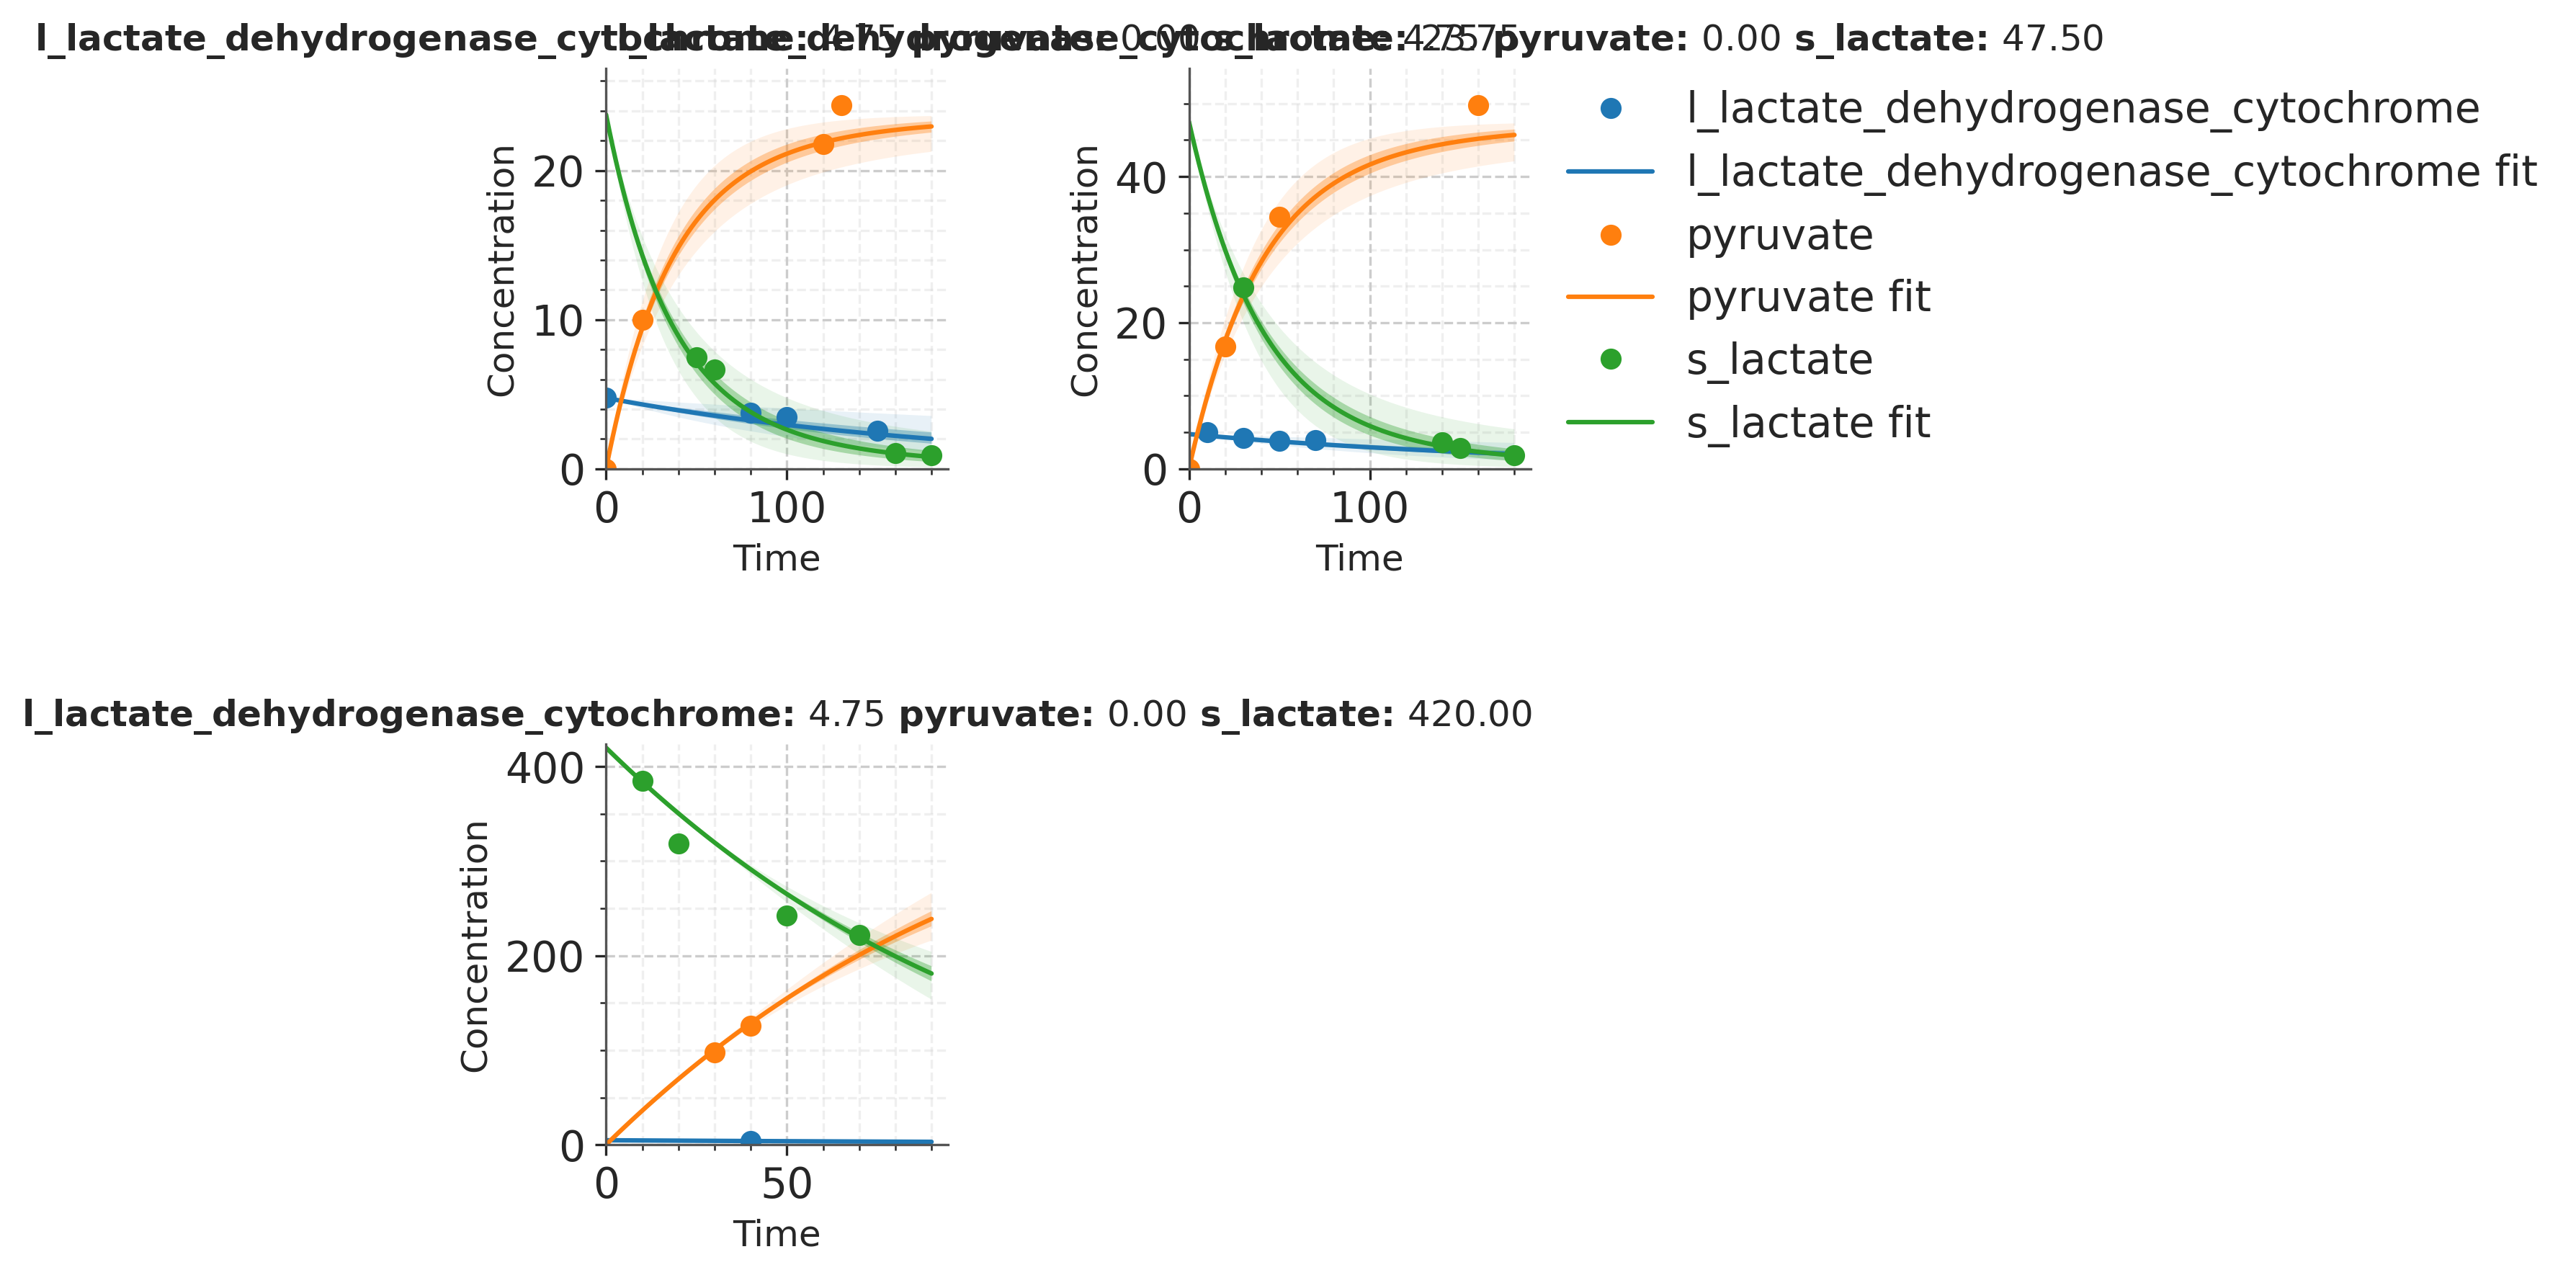

In [7]:
masked_results.plot_ess(show=True)
masked_results.plot_corner(show=True)
padded_dataset.plot(
    predictor=masked_fitted_model,
    show=True,
)